<a href="https://colab.research.google.com/github/rutuja-patil24/CMPE-258-Deep_Learning/blob/main/Assignment_09/02_b_video_transfer_learning_action_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 1: Imports and Setup

In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Constants
IMAGE_SIZE = 64
FRAMES = 8
NUM_CLASSES = 3
BATCH_SIZE = 1


## Step 2: Synthetic Video Dataset Generator

In [20]:

def make_synthetic_dataset(num_samples):
    def _generator():
        for i in range(num_samples):
            video = tf.random.uniform([FRAMES, IMAGE_SIZE, IMAGE_SIZE, 3], dtype=tf.float32)
            label = tf.random.uniform([], minval=0, maxval=NUM_CLASSES, dtype=tf.int32)
            yield video, label

    output_signature = (
        tf.TensorSpec(shape=(FRAMES, IMAGE_SIZE, IMAGE_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
    return tf.data.Dataset.from_generator(_generator, output_signature=output_signature)

train_ds = make_synthetic_dataset(20).batch(BATCH_SIZE).prefetch(1)
val_ds = make_synthetic_dataset(10).batch(BATCH_SIZE).prefetch(1)


## Step 3: Build Lightweight 3D Conv Video Model

In [21]:
def build_lightweight_video_model():
    inputs = tf.keras.Input(shape=(FRAMES, IMAGE_SIZE, IMAGE_SIZE, 3))
    x = tf.keras.layers.Conv3D(8, kernel_size=(3, 3, 3), activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

model = build_lightweight_video_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 8, 64, 64, 3)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d (Conv3D)                      │ (None, 6, 62, 62, 8)        │             656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 3, 31, 31, 8)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 23064)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │         738,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 738,835 (2.82 MB)

 Trainable params: 738,835 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

## Step 4: Train the Model

In [22]:
history = model.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
     15/Unknown 4s 4ms/step - accuracy: 0.4676 - loss: 5.9285

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.4894 - loss: 5.1765 - val_accuracy: 0.3000 - val_loss: 1.8262
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1946 - loss: 1.5420 - val_accuracy: 0.4000 - val_loss: 1.1208
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6035 - loss: 1.0877 - val_accuracy: 0.4000 - val_loss: 1.0754
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3063 - loss: 1.1938 - val_accuracy: 0.4000 - val_loss: 1.1068
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3933 - loss: 1.1076 - val_accuracy: 0.4000 - val_loss: 1.0925


## Step 5: Training & Validation Curves

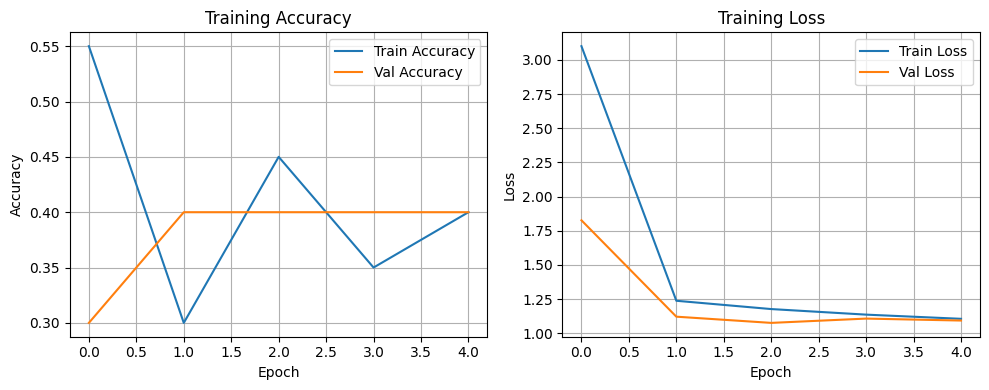

In [23]:
plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Step 6: Visualize One Synthetic Video Sample

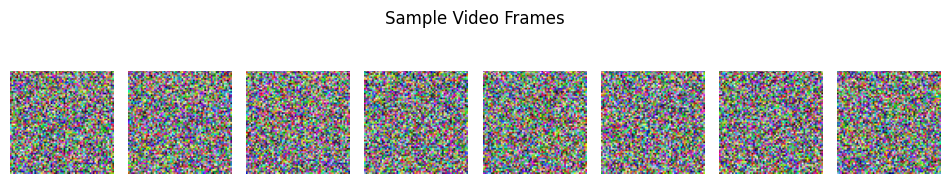

In [25]:
def show_video_clip(video_tensor):
    fig, axes = plt.subplots(1, FRAMES, figsize=(FRAMES * 1.2, 2))
    for i in range(FRAMES):
        axes[i].imshow(video_tensor[i])
        axes[i].axis('off')
    plt.suptitle("Sample Video Frames")
    plt.tight_layout()
    plt.show()

# Pick one random video from training set
for videos, labels in train_ds.take(1):
    show_video_clip(videos[0])
